# Activity NN
## Tyler Barna

### Contents
1. [Import Modules and Data](#import)
2. [Visualizing Data](#data)  
3. [Analysis](#analysis)    
    3.1 [Analysis 1](#analysis1)

### 1. Import Modules and Data
<a id='import'></a>

In [40]:
import csv
import dis
import inspect
import os
import sys
import time

import arviz as az
import astropy
import astroquery
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import pymc as pm
import random
import scipy as sp
import scipy.stats as stats
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.io import ascii
from astropy.time import Time
from astropy.time import TimeDelta
from astropy.timeseries import TimeSeries
from astropy.visualization import time_support
time_support()
from astropy.visualization import quantity_support
quantity_support()

from IPython.display import display_html
from IPython.display import Image

from numpy import interp

from pymc import Model, Normal, Gamma, find_MAP

from scipy import integrate
from scipy import linalg as la
from scipy import optimize

from scipy.stats import beta
from scipy.stats import betabinom
from scipy.stats import binom
from scipy.stats import gamma
from scipy.stats import invgamma
from scipy.stats import multivariate_normal as mvn
from scipy.stats import nbinom
from scipy.stats import norm
from scipy.stats import poisson
from scipy.stats import t
from scipy.stats import uniform

from sklearn.linear_model import LinearRegression as linreg
from sklearn import preprocessing as preproc

%matplotlib inline
plt.style.use("seaborn-colorblind")
mpl.rcParams.update({"axes.grid" : False})
plt.style.context(("seaborn-colorblind",))
pp = pprint.PrettyPrinter(indent=4)

## set seed for reproducibility
random.seed(5731)

## import data
dfc = pd.read_csv('clusters_xrays.csv')
display(dfc.describe())
dfgc = ascii.read('GC_allcolumns.txt').to_pandas()
display(dfgc.describe())

,LX,Ngal
count,1030.000000,1030.000000
mean,0.050871,13.330097
std,0.089347,16.666854
min,0.000008,3.000000
25%,0.010061,5.000000
50%,0.025341,8.000000
75%,0.049777,14.750000
max,1.014745,154.000000


,RA,DEC,D,e1,A_V,MV_T,e2,M_K,e3,N_GC,...,e5,R_e,e6,M_d,e6_1,M_G,e8,M_B,el,eu
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,...,297.000000,297.000000,297.000000,297.000000,297.00000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,-23.979294,-33.365019,6.907239,-30.678350,0.135367,-20.311178,0.247407,6543.111411,505.170394,2057.814478,...,-2047.718182,-1072.900067,-1110.570505,-2550.573044,-2558.63163,7.812054,0.110606,-7876.753838,-7877.476936,-7877.975253
std,580.790966,581.191404,584.606585,580.385908,0.196881,2.126069,0.116528,81948.005957,8306.564171,4510.222699,...,4049.288834,3107.041290,3147.838511,4375.297599,4370.56382,1.113858,0.060663,4096.998665,4095.602673,4094.640323
min,-9999.000000,-9999.000000,-9999.000000,-9999.000000,0.000000,-24.190000,0.200000,-9999.000000,-9999.000000,0.000000,...,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.00000,5.140000,0.000000,-9999.000000,-9999.000000,-9999.000000
25%,3.669255,-33.233927,15.820000,0.560000,0.044000,-21.850000,0.200000,-25.065000,0.102000,50.000000,...,2.400000,1.220000,0.050000,-9999.000000,-9999.00000,7.040000,0.070000,-9999.000000,-9999.000000,-9999.000000
50%,11.699267,8.154306,20.150000,1.500000,0.084000,-20.800000,0.200000,-23.713000,0.104000,220.000000,...,4.600000,2.460000,0.160000,10.571000,0.03200,7.780000,0.110000,-9999.000000,-9999.000000,-9999.000000
75%,12.882202,27.060767,36.200000,4.090000,0.157000,-19.060000,0.250000,-21.708000,0.110000,1497.000000,...,8.600000,4.800000,0.410000,11.284000,0.04600,8.660000,0.130000,-9999.000000,-9999.000000,-9999.000000
max,23.641519,75.370944,284.200000,19.900000,2.583000,-13.000000,1.440000,999999.000000,99999.000000,32500.000000,...,46.500000,55.000000,20.000000,12.726000,0.21000,10.120000,0.570000,10.320000,9.950000,0.620000


### 2. Visualizing Data
<a id='data'></a>

There's only two columns in this dataset, so we can easily visualize it.

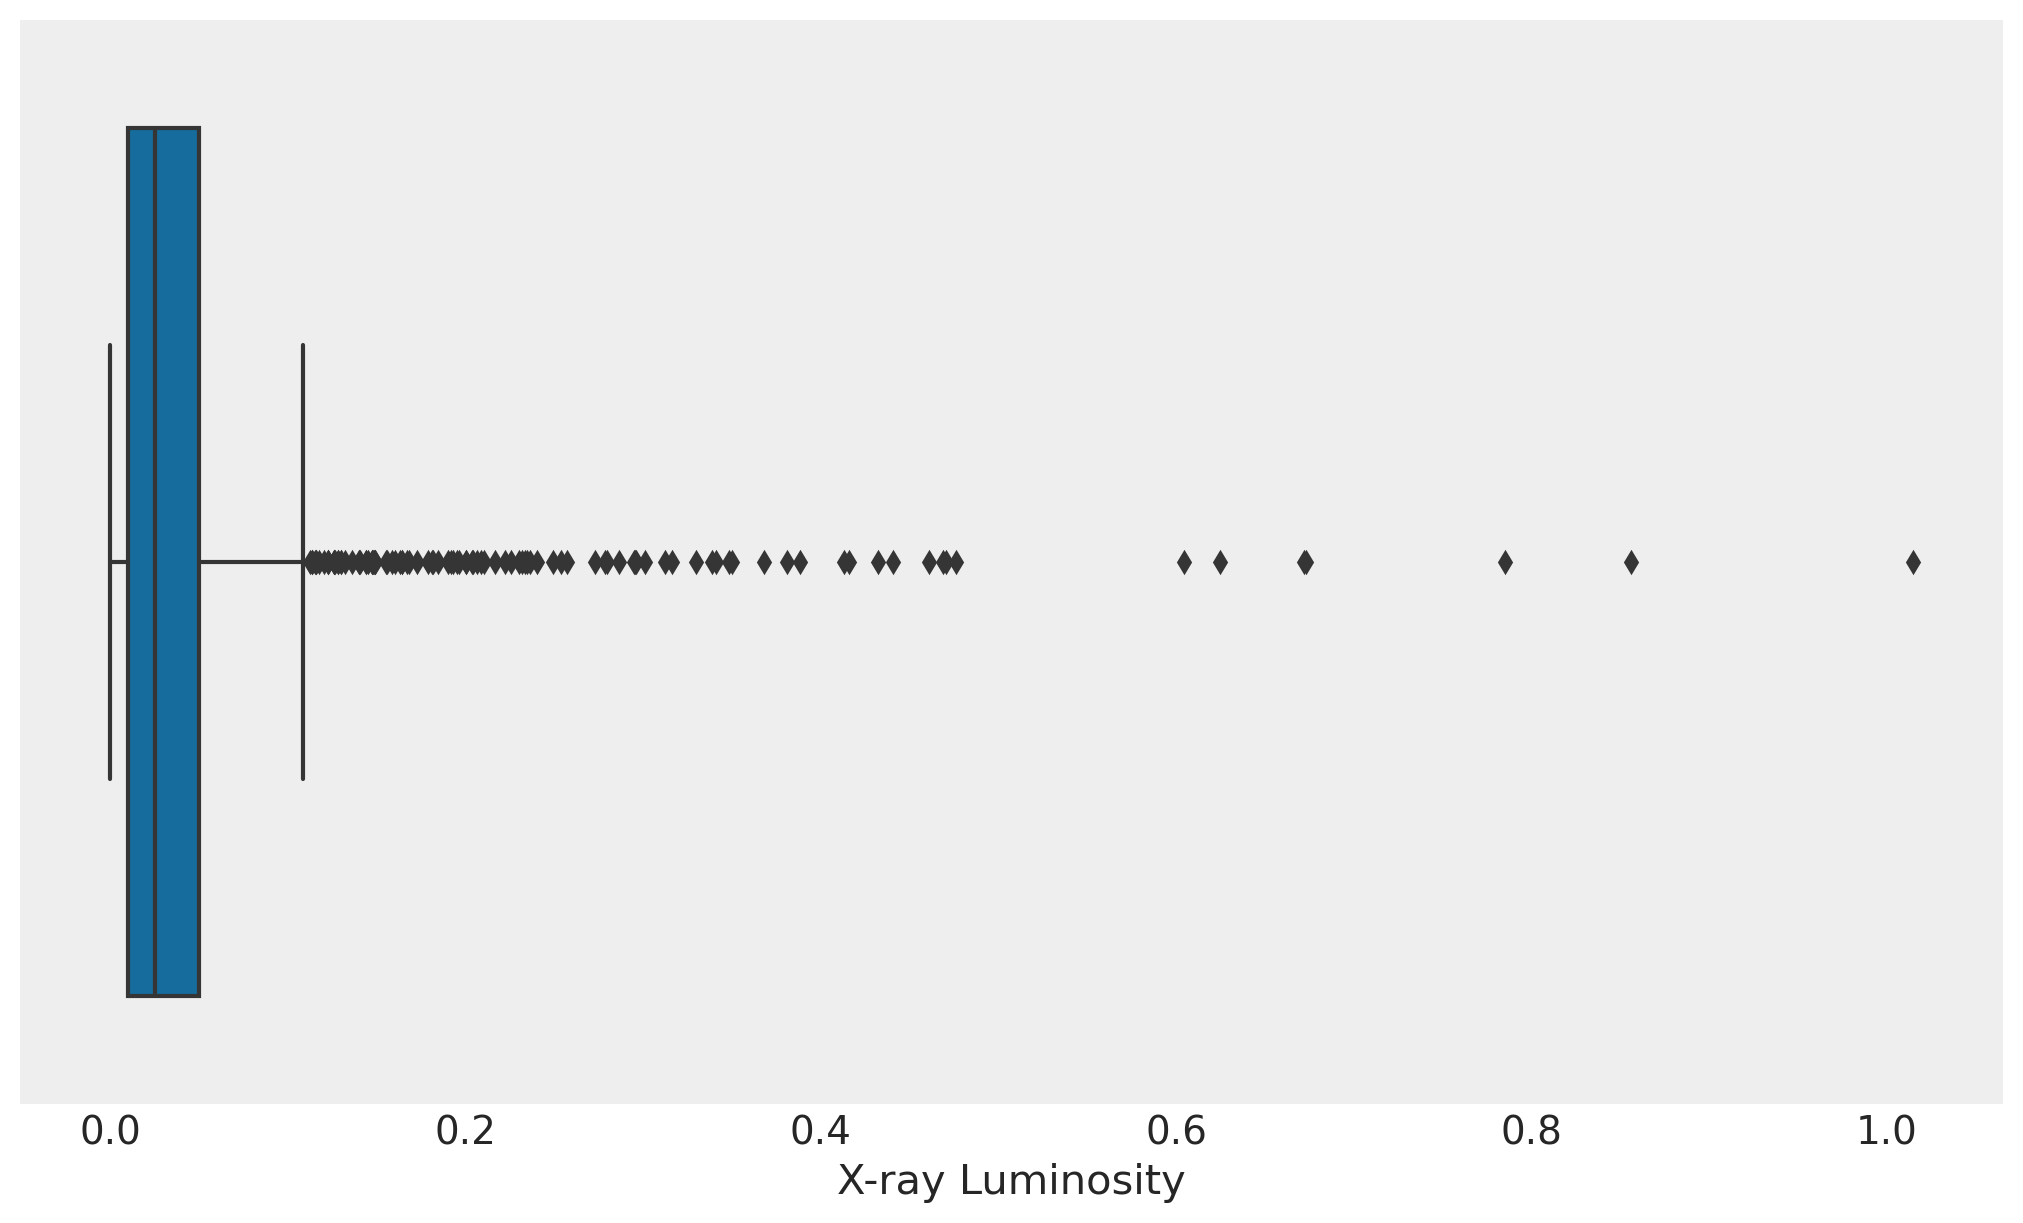

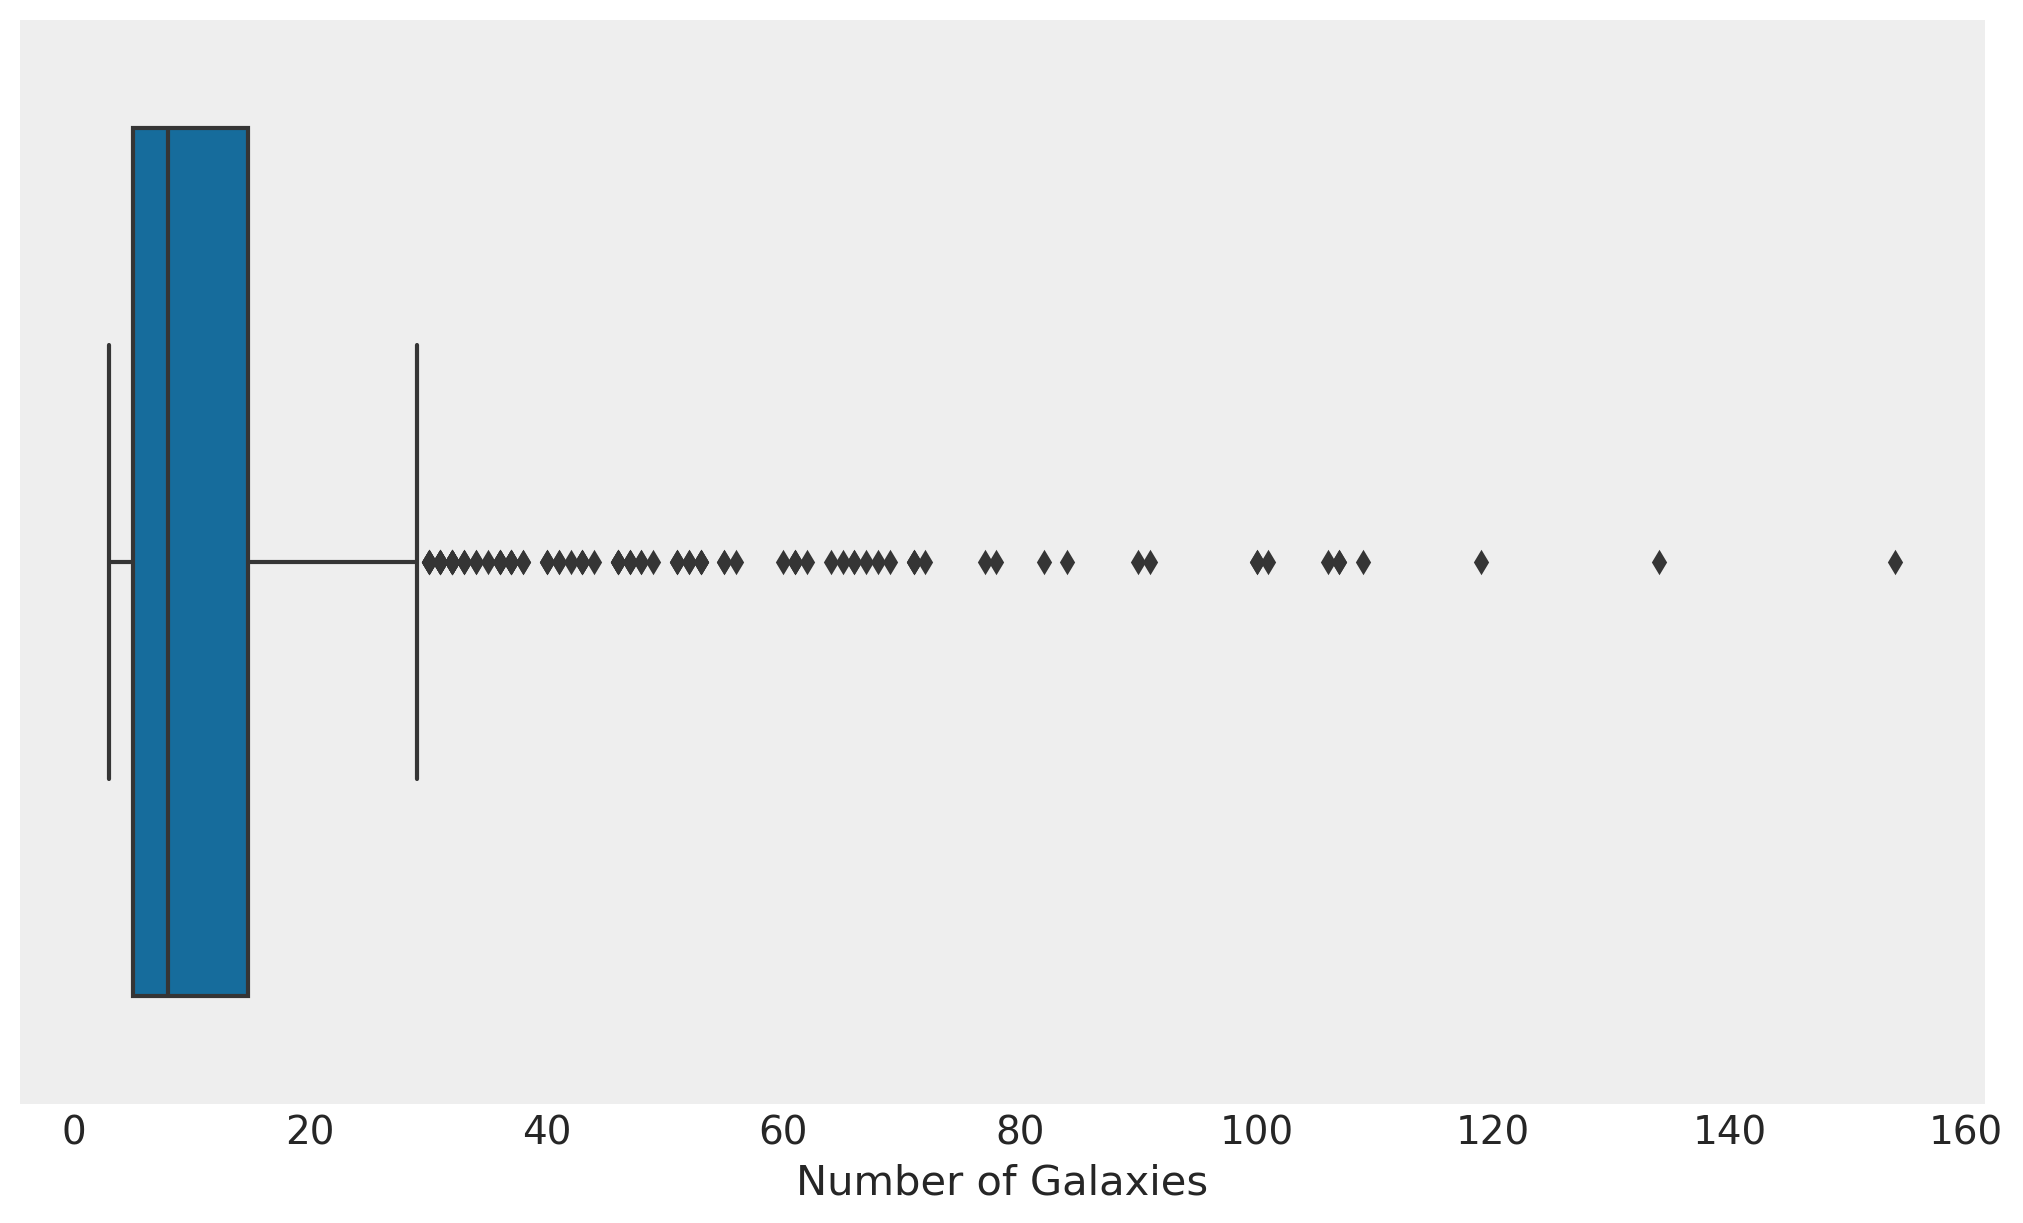

<Figure size 800x800 with 0 Axes>

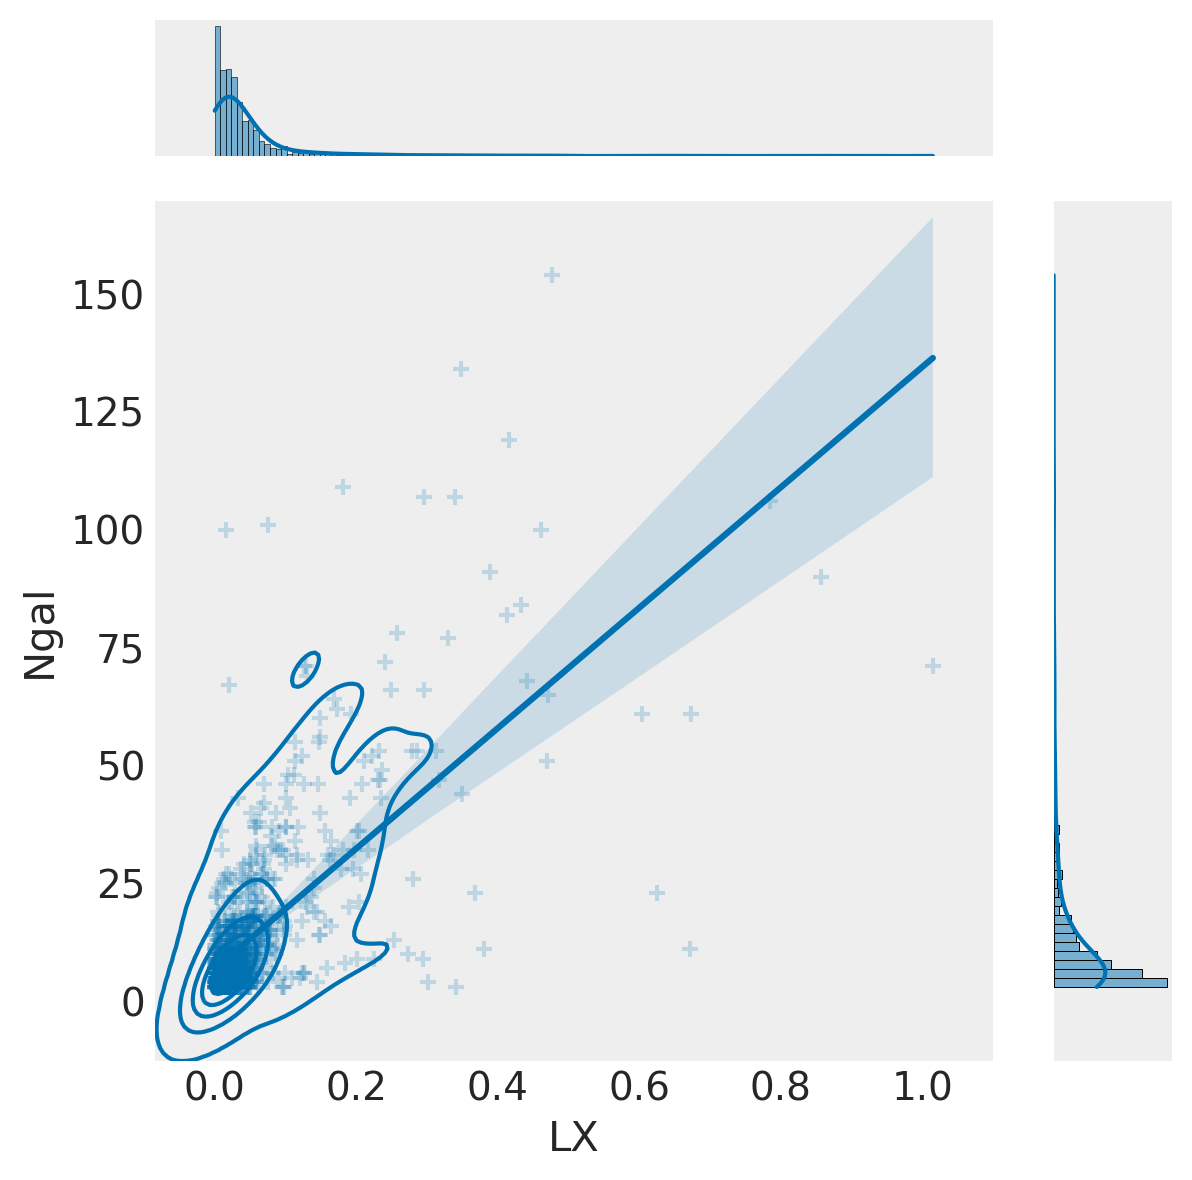

In [41]:
## plot box chart of X-ray luminosity
fig, ax = plt.subplots(figsize=(10, 6))
plot = sns.boxplot(data=dfc, x='LX', ax=ax)
ax.set_xlabel('X-ray Luminosity')
plt.show()

## plot box chart of NGal
fig, ax = plt.subplots(figsize=(10, 6))
plot = sns.boxplot(data=dfc, x='Ngal', ax=ax)
ax.set_xlabel('Number of Galaxies')
plt.show()

## plot kdeplot of LX and Ngal
ax = plt.figure(figsize=(8, 8))
plot = sns.jointplot(data=dfc, x='LX', y='Ngal', 
                     kind='reg', marker='+', ax=ax,
                     joint_kws = {'scatter_kws':dict(alpha=0.2)})
plot.plot_joint(sns.kdeplot, zorder=0, levels=6)
# ax.set_xlabel('X-ray Luminosity')
# ax.set_ylabel('Number of Galaxies')
plt.show()

### 3. Analysis
<a id='analysis'></a>

#### 3.1 Analysis 1
<a id='analysis1'></a>